In [1]:
#!python3 -m pip install cityscapesscripts

In [2]:
#!python -m pip install cityscapesscripts[gui]
# need it?

In [3]:
from PIL import Image
from cityscapesscripts.helpers import labels
import matplotlib.pyplot as plt
import numpy as np
import os
import random
import time
from tqdm.auto import tqdm
import torch
import torch.nn.functional as F
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import random_split
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from torchvision.models.segmentation import deeplabv3_resnet50, DeepLabV3_ResNet50_Weights

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [4]:
# Set seeds for reproducibility
def set_seeds(seed=42):
    """Set seeds for reproducibility"""
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

# Set the seed
SEED = 42
set_seeds(SEED)
print(f"Seeds set for reproducibility is {SEED}")

Seeds set for reproducibility is 42


In [5]:
DEVICE = torch.device("cuda" if torch.cuda.is_available() 
                      else "mps" if torch.mps.is_available() 
                      else "cpu"
                    )
print(DEVICE)

mps


Actual Colors:


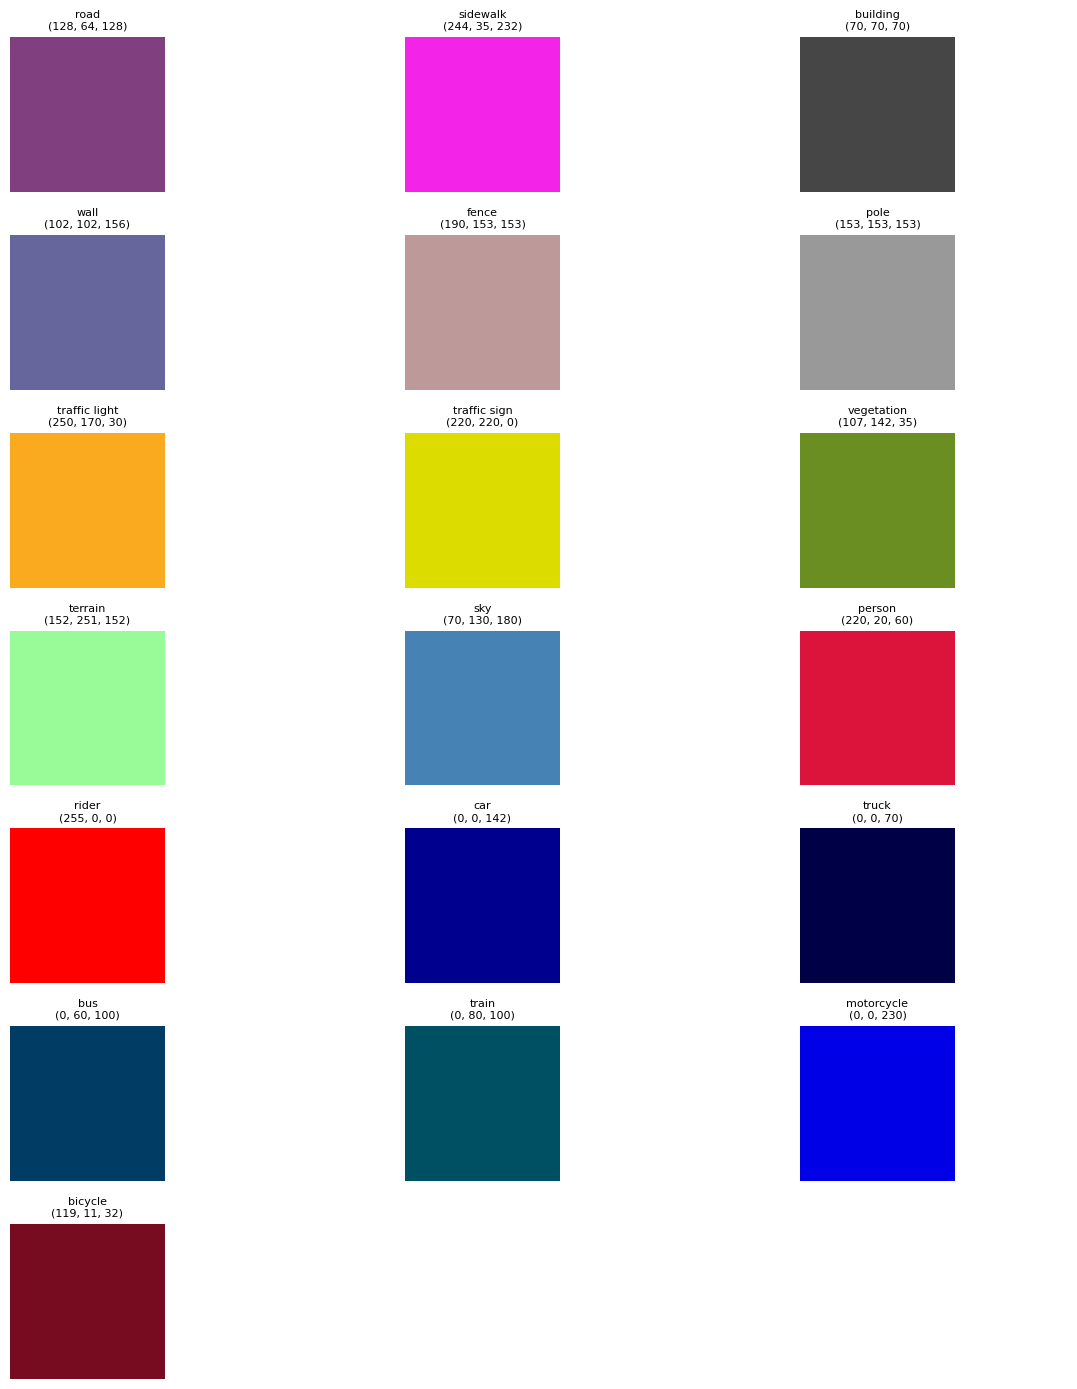

In [6]:
print("Actual Colors:")

# Calculate grid dimensions (3 colors per row)
cols = 3

labels = [label for label in labels.labels if label.trainId != 255 and label.trainId != -1]
rows = (len(labels) + cols - 1) // cols  # Ceiling division

# Create a figure and axes to display the colors in a grid
fig, axes = plt.subplots(rows, cols, figsize=(12, rows * 2))

# Flatten axes array for easier indexing
if rows == 1:
    axes = [axes] if cols == 1 else axes
else:
    axes = axes.flatten()

for i, label in enumerate(labels): 
    color = np.array(label.color) / 255.0  # Normalize RGB values to [0, 1]
    axes[i].imshow([[color]])  # Display the color as a small image
    # Add color name and RGB values to the title
    axes[i].set_title(f"{label.name}\n{label.color}", fontsize=8)
    axes[i].axis('off')  # Hide the axes

# Hide any unused subplots
for i in range(len(labels), len(axes)):
    axes[i].axis('off')

plt.tight_layout()
plt.show()

In [7]:
class SegmentationDataset(Dataset):
    def __init__(self, images_dir, targets_dir, image_transform=None, target_transform=None):
        """
        Args:
            images_dir (string): Directory with all the images.
            targets_dir (string): Directory with all the target masks.
            image_transform (callable, optional): Optional transform to be applied on images.
            target_transform (callable, optional): Optional transform to be applied on targets.
        """
        self.images_dir = images_dir
        self.targets_dir = targets_dir
        self.image_transform = image_transform
        self.target_transform = target_transform
        
        # Get all image filenames
        self.image_filenames = [f for f in os.listdir(images_dir) 
                               if f.lower().endswith(('.png'))]
        self.image_filenames.sort()
        
    def __len__(self):
        return len(self.image_filenames)
    
    def __getitem__(self, idx):
        # Load image
        img_name = self.image_filenames[idx]
        img_path = os.path.join(self.images_dir, img_name)
        image = Image.open(img_path).convert('RGB')
        
        # Load target mask
        target_name = img_name.replace('.png', '_trainId.png')
        target_path = os.path.join(self.targets_dir, target_name)
        target = Image.open(target_path)
        
        # Apply transforms
        if self.image_transform:
            image = self.image_transform(image)
        
        if self.target_transform:
            target = self.target_transform(target)
       # else:
       #     # Default: convert to tensor
       #     target = torch.from_numpy(target)
        
        return image, target

In [8]:
path_images = "syn_resized_images"
path_target = "syn_resized_gt"

image_transform = transforms.Compose([
    transforms.Resize((256, 466)), # We maintain the og aspect ratio
    transforms.ToTensor(),  # Converts PIL Image to Tensor
])

target_transform = transforms.Compose([
    transforms.Resize((256, 466), interpolation=Image.NEAREST), # This interpolation ensure that all pixels have a correct value of their class
    transforms.Lambda(lambda x: torch.from_numpy(np.array(x)).long())
])
syn_dataset = SegmentationDataset(images_dir=path_images, targets_dir=path_target, image_transform=image_transform, target_transform=target_transform)


In [9]:
# Get total dataset size
total_size = len(syn_dataset)
print(f"Total dataset size: {total_size}")

# Calculate split sizes (60% train, 10% val, 30% test)
train_size = int(0.6 * total_size)
val_size = int(0.1 * total_size)
test_size = total_size - train_size - val_size

print(f"Train size: {train_size} ({train_size/total_size*100:.1f}%)")
print(f"Validation size: {val_size} ({val_size/total_size*100:.1f}%)")
print(f"Test size: {test_size} ({test_size/total_size*100:.1f}%)")

# Create random splits
syn_train_dataset, syn_val_dataset, syn_test_dataset = random_split(
    syn_dataset, 
    [train_size, val_size, test_size],
    generator=torch.Generator().manual_seed(SEED)  # For reproducibility
)

# Create DataLoaders
batch_size = 10  


syn_train_dataloader = DataLoader(
    syn_train_dataset,
    batch_size=batch_size,
    shuffle=True,
    #num_workers=2,
    generator=torch.Generator().manual_seed(SEED) 
)


syn_val_dataloader = DataLoader(
    syn_val_dataset,
    batch_size=batch_size,
    shuffle=True,  
    #num_workers=2,
    generator=torch.Generator().manual_seed(SEED)
)

syn_test_dataloader = DataLoader(
    syn_test_dataset,
    batch_size=batch_size,
    shuffle=True,  
    #num_workers=2,
    generator=torch.Generator().manual_seed(SEED)
)

print(f"\nDataLoaders created:")
print(f"Train batches: {len(syn_train_dataloader)}")
print(f"Validation batches: {len(syn_val_dataloader)}")
print(f"Test batches: {len(syn_test_dataloader)}")

Total dataset size: 12500
Train size: 7500 (60.0%)
Validation size: 1250 (10.0%)
Test size: 3750 (30.0%)

DataLoaders created:
Train batches: 750
Validation batches: 125
Test batches: 375


In [10]:
import ssl
import urllib.request
from contextlib import contextmanager
# Disable SSL verification for urllib requests on MacOS
# This is a workaround for the "SSL: CERTIFICATE_VERIFY_FAILED" error on MacOS
@contextmanager
def no_ssl_verification():
    """Temporarily disable SSL verification"""
    old_context = ssl._create_default_https_context
    ssl._create_default_https_context = ssl._create_unverified_context
    try:
        yield
    finally:
        ssl._create_default_https_context = old_context
        

if DEVICE.type == 'mps': 
    print("mps detected, using no_ssl_verification")
    with no_ssl_verification():
        WEIGHTS = DeepLabV3_ResNet50_Weights.COCO_WITH_VOC_LABELS_V1
        model = deeplabv3_resnet50(weights=WEIGHTS)
else:
    WEIGHTS = DeepLabV3_ResNet50_Weights.COCO_WITH_VOC_LABELS_V1
    model = deeplabv3_resnet50(weights=WEIGHTS)

NUM_CLASSES = 19  # Cityscapes
LR = 1e-4

model.classifier[4] = nn.Conv2d(256, NUM_CLASSES, kernel_size=1)
model.to(DEVICE)

criterion = nn.CrossEntropyLoss(ignore_index=255)  # 255 = unlabeled

optimizer = optim.Adam(model.parameters(), lr=LR)


mps detected, using no_ssl_verification


In [11]:
def compute_iou(preds, labels, num_classes, ignore_index=255):
    preds = torch.argmax(preds, dim=1)  # [B, H, W]
    ious = []
    
    for cls in range(num_classes):
        pred_inds = (preds == cls)
        target_inds = (labels == cls)
        
        # Escludi pixel ignorati
        mask = (labels != ignore_index)
        pred_inds = pred_inds & mask
        target_inds = target_inds & mask

        intersection = (pred_inds & target_inds).sum().item()
        union = (pred_inds | target_inds).sum().item()
        
        if union == 0:
            continue  # salta classe non presente
        ious.append(intersection / union)
    
    if len(ious) == 0:
        return float('nan')  # o 0.0 se preferisci
    return sum(ious) / len(ious)

In [12]:
def train_and_validate_epoch(model, train_dataloader, val_dataloader, optimizer, criterion):
    """
    Train for one epoch and validate on validation set
    Returns: train_loss, train_iou, val_loss, val_iou
    """
    # Training phase
    model.train()
    train_total_loss = 0
    train_total_iou = 0
    
    for images, masks in tqdm(train_dataloader, desc="Training"):
        images = images.to(DEVICE)
        masks = masks.to(DEVICE)

        optimizer.zero_grad()
        outputs = model(images)['out']
        loss = criterion(outputs, masks)
        loss.backward()
        optimizer.step()

        train_total_loss += loss.item()
        train_total_iou += compute_iou(outputs.detach(), masks, NUM_CLASSES)

    train_avg_loss = train_total_loss / len(train_dataloader)
    train_avg_iou = train_total_iou / len(train_dataloader)
    
    # Validation phase
    model.eval()
    val_total_loss = 0
    val_total_iou = 0
    
    with torch.no_grad():
        for images, masks in tqdm(val_dataloader, desc="Validating"):
            images = images.to(DEVICE)
            masks = masks.to(DEVICE)
            
            outputs = model(images)['out']
            loss = criterion(outputs, masks)
            
            val_total_loss += loss.item()
            val_total_iou += compute_iou(outputs, masks, NUM_CLASSES)
    
    val_avg_loss = val_total_loss / len(val_dataloader)
    val_avg_iou = val_total_iou / len(val_dataloader)
    
    return train_avg_loss, train_avg_iou, val_avg_loss, val_avg_iou

In [13]:
epochs = 15

# Create models directory if it doesn't exist
import os
os.makedirs("models", exist_ok=True)

# Store metrics for plotting
train_losses = []
train_ious = []
val_losses = []
val_ious = []

# Track best validation IoU for saving best model
best_val_iou = 0.0
start = time.time()

for epoch in range(epochs):
    print(f"Epoch {epoch+1}/{epochs}")
    
    # Train and validate in one go
    train_loss, train_iou, val_loss, val_iou = train_and_validate_epoch(
        model, syn_train_dataloader, syn_val_dataloader, optimizer, criterion
    )
    
    # Store metrics
    train_losses.append(train_loss)
    train_ious.append(train_iou)
    val_losses.append(val_loss)
    val_ious.append(val_iou)
    
    # Print results
    print(f"Train Loss: {train_loss:.4f} | Train IoU: {train_iou:.4f}")
    print(f"Val Loss: {val_loss:.4f} | Val IoU: {val_iou:.4f}")
    
    # Save checkpoint after each epoch
    checkpoint = {
        "epoch": epoch + 1,
        "model_state_dict": model.state_dict(),
        "optimizer_state_dict": optimizer.state_dict(),
        "train_loss": train_loss,
        "train_iou": train_iou,
        "val_loss": val_loss,
        "val_iou": val_iou,
        "train_losses": train_losses,
        "train_ious": train_ious,
        "val_losses": val_losses,
        "val_ious": val_ious,
        "num_classes": NUM_CLASSES,
        "learning_rate": LR,
    }
    
    
    # Save best model based on validation IoU
    if val_iou > best_val_iou:
        best_val_iou = val_iou
        best_model_path = "models/deeplabv3_best_model.pth"
        torch.save(checkpoint, best_model_path)
        print(f"New best model saved: {best_model_path} (Val IoU: {val_iou:.4f})")
    
    checkpoint_path = f"models/deeplabv3_epoch_{epoch+1}.pth"
    torch.save(checkpoint, checkpoint_path)
    print(f"Checkpoint saved: {checkpoint_path}")

    # Delete old checkpoints if they exist
    checkpoint_delete = f"models/deeplabv3_epoch_{epoch}.pth"
    if os.path.exists(checkpoint_delete):
        os.remove(checkpoint_delete)
        print(f"Deleted old checkpoint: {checkpoint_delete}")
    
    print("-" * 50)
end = time.time()
print(f"\nTraining completed in {end - start:.2f} seconds, with {epochs} epochs.")
print(f"Best validation IoU: {best_val_iou:.4f}")
print(f"Final model saved as: models/deeplabv3_epoch_{epochs}.pth")
print(f"Best model saved as: models/deeplabv3_best_model.pth")

Epoch 1/15


Validating: 100%|██████████| 125/125 [02:18<00:00,  1.11s/it]


Train Loss: 0.6000 | Train IoU: 0.3387
Val Loss: 0.3409 | Val IoU: 0.4113
New best model saved: models/deeplabv3_best_model.pth (Val IoU: 0.4113)
Checkpoint saved: models/deeplabv3_epoch_1.pth
--------------------------------------------------
Epoch 2/15


Validating: 100%|██████████| 125/125 [02:21<00:00,  1.13s/it]


Train Loss: 0.3184 | Train IoU: 0.4326
Val Loss: 0.2855 | Val IoU: 0.4468
New best model saved: models/deeplabv3_best_model.pth (Val IoU: 0.4468)
Checkpoint saved: models/deeplabv3_epoch_2.pth
Deleted old checkpoint: models/deeplabv3_epoch_1.pth
--------------------------------------------------
Epoch 3/15


Validating: 100%|██████████| 125/125 [02:20<00:00,  1.13s/it]


Train Loss: 0.2633 | Train IoU: 0.4733
Val Loss: 0.2597 | Val IoU: 0.4711
New best model saved: models/deeplabv3_best_model.pth (Val IoU: 0.4711)
Checkpoint saved: models/deeplabv3_epoch_3.pth
Deleted old checkpoint: models/deeplabv3_epoch_2.pth
--------------------------------------------------
Epoch 4/15


Validating: 100%|██████████| 125/125 [02:20<00:00,  1.12s/it]


Train Loss: 0.2326 | Train IoU: 0.5130
Val Loss: 0.2942 | Val IoU: 0.4843
New best model saved: models/deeplabv3_best_model.pth (Val IoU: 0.4843)
Checkpoint saved: models/deeplabv3_epoch_4.pth
Deleted old checkpoint: models/deeplabv3_epoch_3.pth
--------------------------------------------------
Epoch 5/15


Validating: 100%|██████████| 125/125 [02:18<00:00,  1.10s/it]


Train Loss: 0.2075 | Train IoU: 0.5433
Val Loss: 0.2837 | Val IoU: 0.4868
New best model saved: models/deeplabv3_best_model.pth (Val IoU: 0.4868)
Checkpoint saved: models/deeplabv3_epoch_5.pth
Deleted old checkpoint: models/deeplabv3_epoch_4.pth
--------------------------------------------------
Epoch 6/15


Validating: 100%|██████████| 125/125 [02:18<00:00,  1.11s/it]


Train Loss: 0.1967 | Train IoU: 0.5574
Val Loss: 0.2310 | Val IoU: 0.5297
New best model saved: models/deeplabv3_best_model.pth (Val IoU: 0.5297)
Checkpoint saved: models/deeplabv3_epoch_6.pth
Deleted old checkpoint: models/deeplabv3_epoch_5.pth
--------------------------------------------------
Epoch 7/15


Validating: 100%|██████████| 125/125 [02:18<00:00,  1.10s/it]


Train Loss: 0.1849 | Train IoU: 0.5747
Val Loss: 0.2301 | Val IoU: 0.5238
Checkpoint saved: models/deeplabv3_epoch_7.pth
Deleted old checkpoint: models/deeplabv3_epoch_6.pth
--------------------------------------------------
Epoch 8/15


Validating: 100%|██████████| 125/125 [02:18<00:00,  1.11s/it]


Train Loss: 0.1708 | Train IoU: 0.5914
Val Loss: 0.2187 | Val IoU: 0.5480
New best model saved: models/deeplabv3_best_model.pth (Val IoU: 0.5480)
Checkpoint saved: models/deeplabv3_epoch_8.pth
Deleted old checkpoint: models/deeplabv3_epoch_7.pth
--------------------------------------------------
Epoch 9/15


Validating: 100%|██████████| 125/125 [02:18<00:00,  1.11s/it]


Train Loss: 0.1594 | Train IoU: 0.6032
Val Loss: 0.2190 | Val IoU: 0.5489
New best model saved: models/deeplabv3_best_model.pth (Val IoU: 0.5489)
Checkpoint saved: models/deeplabv3_epoch_9.pth
Deleted old checkpoint: models/deeplabv3_epoch_8.pth
--------------------------------------------------
Epoch 10/15


Validating: 100%|██████████| 125/125 [02:17<00:00,  1.10s/it]


Train Loss: 0.1786 | Train IoU: 0.5847
Val Loss: 0.2299 | Val IoU: 0.5322
Checkpoint saved: models/deeplabv3_epoch_10.pth
Deleted old checkpoint: models/deeplabv3_epoch_9.pth
--------------------------------------------------
Epoch 11/15


Validating: 100%|██████████| 125/125 [02:18<00:00,  1.10s/it]


Train Loss: 0.1566 | Train IoU: 0.6099
Val Loss: 0.2134 | Val IoU: 0.5556
New best model saved: models/deeplabv3_best_model.pth (Val IoU: 0.5556)
Checkpoint saved: models/deeplabv3_epoch_11.pth
Deleted old checkpoint: models/deeplabv3_epoch_10.pth
--------------------------------------------------
Epoch 12/15


Validating: 100%|██████████| 125/125 [02:18<00:00,  1.11s/it]


Train Loss: 0.1416 | Train IoU: 0.6300
Val Loss: 0.2060 | Val IoU: 0.5655
New best model saved: models/deeplabv3_best_model.pth (Val IoU: 0.5655)
Checkpoint saved: models/deeplabv3_epoch_12.pth
Deleted old checkpoint: models/deeplabv3_epoch_11.pth
--------------------------------------------------
Epoch 13/15


Validating: 100%|██████████| 125/125 [02:18<00:00,  1.10s/it]


Train Loss: 0.1357 | Train IoU: 0.6372
Val Loss: 0.2111 | Val IoU: 0.5683
New best model saved: models/deeplabv3_best_model.pth (Val IoU: 0.5683)
Checkpoint saved: models/deeplabv3_epoch_13.pth
Deleted old checkpoint: models/deeplabv3_epoch_12.pth
--------------------------------------------------
Epoch 14/15


Validating: 100%|██████████| 125/125 [02:18<00:00,  1.11s/it]


Train Loss: 0.1321 | Train IoU: 0.6446
Val Loss: 0.2131 | Val IoU: 0.5642
Checkpoint saved: models/deeplabv3_epoch_14.pth
Deleted old checkpoint: models/deeplabv3_epoch_13.pth
--------------------------------------------------
Epoch 15/15


Validating: 100%|██████████| 125/125 [02:18<00:00,  1.10s/it]


Train Loss: 0.1705 | Train IoU: 0.6041
Val Loss: 0.2155 | Val IoU: 0.5544
Checkpoint saved: models/deeplabv3_epoch_15.pth
Deleted old checkpoint: models/deeplabv3_epoch_14.pth
--------------------------------------------------

Training completed in 33306.05 seconds, with 15 epochs.
Best validation IoU: 0.5683
Final model saved as: models/deeplabv3_epoch_15.pth
Best model saved as: models/deeplabv3_best_model.pth


Visualizing segmentation results...


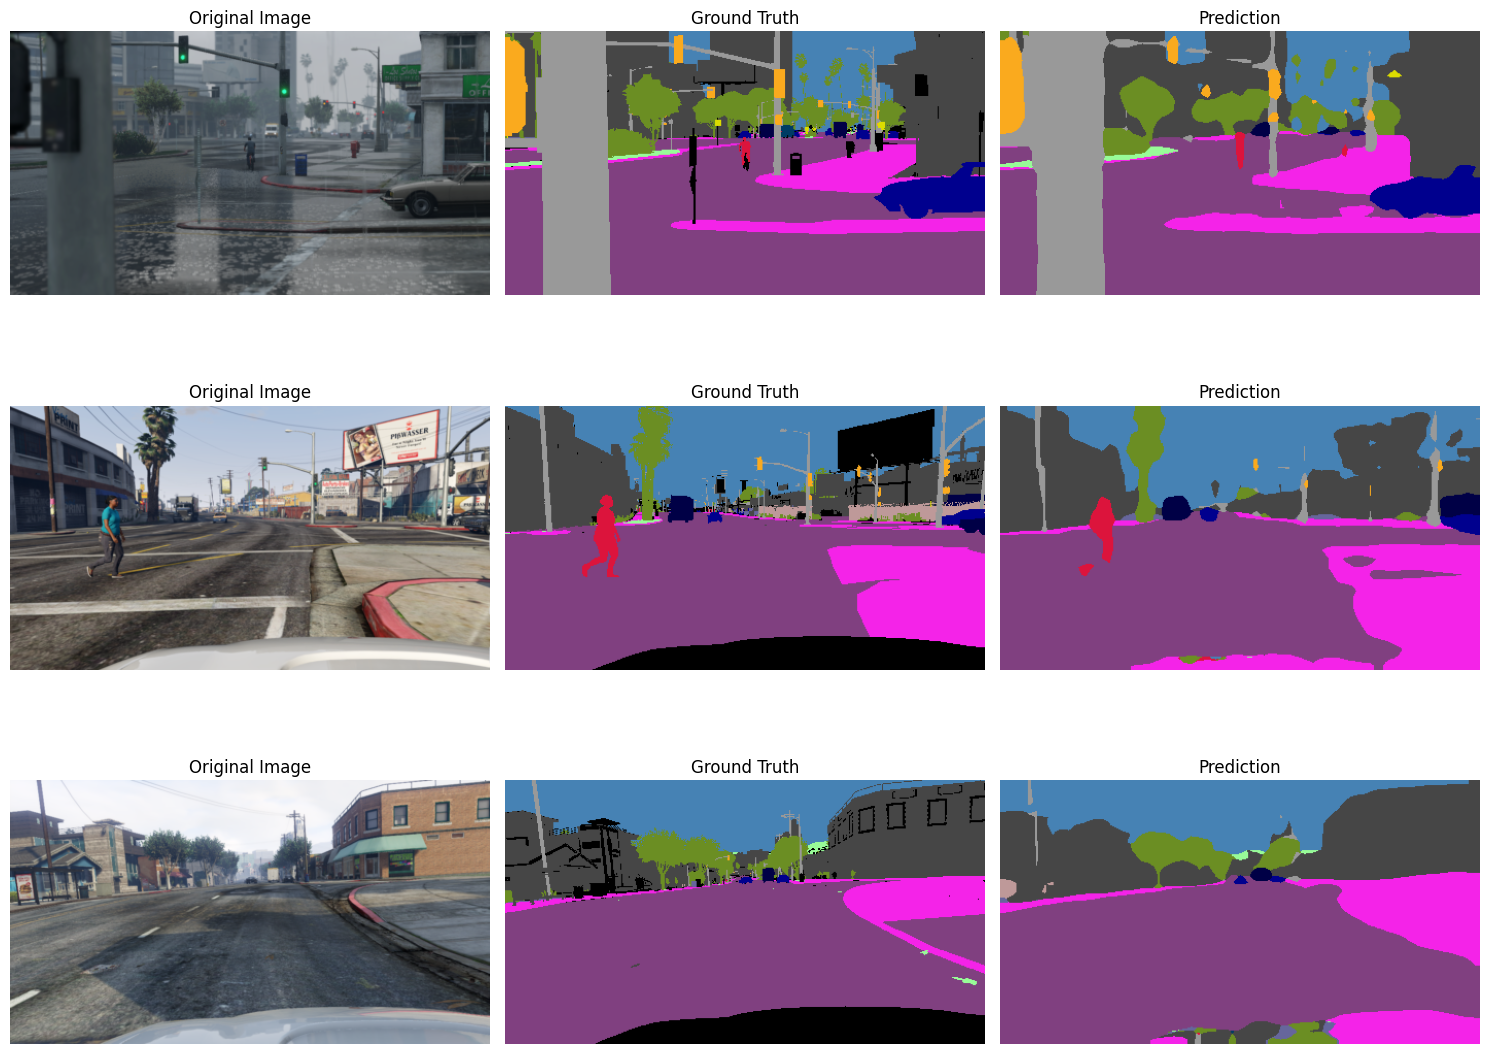


Training examples:


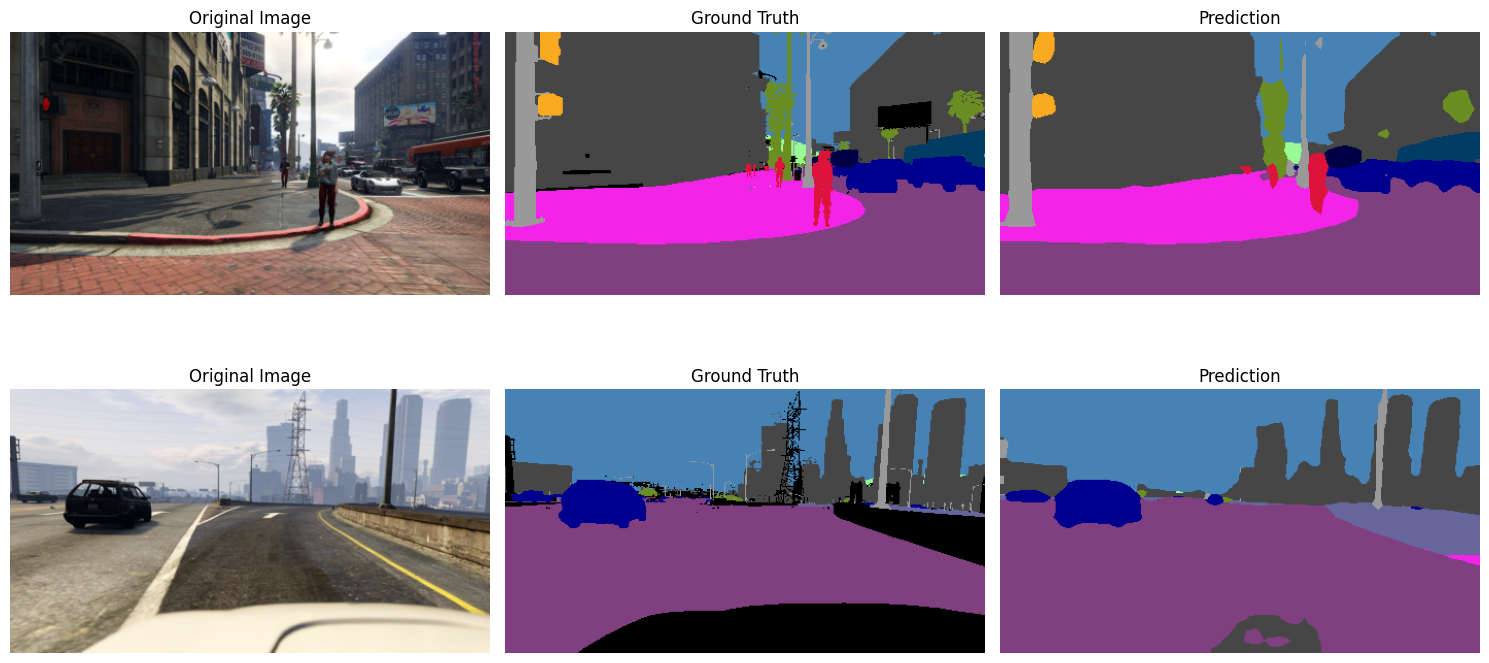

In [14]:
# Create color map for segmentation (using Cityscapes colors)
from cityscapesscripts.helpers import labels as cs_labels
def visualize_segmentation(model, dataloader, num_samples=4):
    """
    Visualize segmentation results from the model
    """
    model.eval()
    
    # Get a batch of data
    images, targets = next(iter(dataloader))
    images = images.to(DEVICE)
    targets = targets.to(DEVICE)
    
    with torch.no_grad():
        outputs = model(images)['out']
        predictions = torch.argmax(outputs, dim=1)
    
    # Move to CPU for visualization
    images = images.cpu()
    targets = targets.cpu()
    predictions = predictions.cpu()
    

    
    def apply_color_map(seg_map):
        """Apply color mapping to segmentation map"""
        colored_map = np.zeros((seg_map.shape[0], seg_map.shape[1], 3), dtype=np.uint8)
        
        # Get valid labels (excluding ignore classes)
        valid_labels = [label for label in cs_labels.labels if label.trainId != 255 and label.trainId != -1]
        
        for label in valid_labels:
            mask = seg_map == label.trainId
            colored_map[mask] = label.color
            
        return colored_map
    
    # Plot results
    fig, axes = plt.subplots(num_samples, 3, figsize=(15, num_samples * 4))
    if num_samples == 1:
        axes = axes.reshape(1, -1)
    
    for i in range(min(num_samples, len(images))):
        # Original image
        img = images[i].permute(1, 2, 0).numpy()
        img = (img - img.min()) / (img.max() - img.min())  # Normalize for display
        axes[i, 0].imshow(img)
        axes[i, 0].set_title('Original Image')
        axes[i, 0].axis('off')
        
        # Ground truth
        gt_colored = apply_color_map(targets[i].numpy())
        axes[i, 1].imshow(gt_colored)
        axes[i, 1].set_title('Ground Truth')
        axes[i, 1].axis('off')
        
        # Prediction
        pred_colored = apply_color_map(predictions[i].numpy())
        axes[i, 2].imshow(pred_colored)
        axes[i, 2].set_title('Prediction')
        axes[i, 2].axis('off')
    
    plt.tight_layout()
    plt.show()

# Visualize segmentation results on validation set
print("Visualizing segmentation results...")
visualize_segmentation(model, syn_val_dataloader, num_samples=3)

# Also show some training examples for comparison
print("\nTraining examples:")
visualize_segmentation(model, syn_train_dataloader, num_samples=2)